#INTRODUCTION

In a nutshell, I will be using a Principal Component Analysis (PCA) based approach to analysing the IMDB dataset and then implementing some KMeans clustering to provide visualisations of any related clusters I find in the dataset. Some caveats : I will not be attempting to run any predictive models ( XGBoosting, SVM, Regression... that sort of thing). This notebook will purely be an exploratory and hopefully concise enough attempt to explain the idea of PCA as well as using a clustering method (KMeans) to extract meaningful relations out of it. 

A very high-level description of PCA is that it serves as a dimensionality reduction method on the features of our original dataset by projecting these features onto a lower dimension. Therefore if our original dataset contains 72 columns ( i.e features) and we manage to reduce these 72 columns down to 9 columns image the gains in time and processing speeds! However the question is how do we get the new data out of the PCA-reduced 9 columns? Via a clustering method!! In this case, I will use KMeans - more to come below. This notebook is organised as follows : 

 1. Filtering the Dataset to remove Null values and get only numerical columns. Standardising the features 
 2. Using the measure of **Explained Variance** to motivate and inform our search on getting the right number of PCA projections. Refer to Sebastian Raschka's awesome piece on Explained variance ( and PCA in general) here : http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html. My notebook heavily borrows from his article so I need to give it a shout-out.
 3. Implementing Principal Component Analysis 
 4. Using KMeans clustering to investigate relationships in the PCA projections (if there are any at all) and creating visualisations using the said clusters.
 5. Pseudo means of extracting KMeans clusters and use those as new features (meta features) in your predictions - STILL UNDER PROGRESS

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA # Principal Component Analysis module
from sklearn.cluster import KMeans # KMeans clustering 
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline 

Let's import the movie dataset with imagination. The dataset will be called "movie" and let's inspect the first 5 rows of the dataframe with .head()

In [58]:
movie = pd.read_csv('/home/parrondo/projects/research/ejemplo/data/raw/2017week32/numerai_datasets/numerai_training_data.csv') # reads the csv and creates the dataframe called movie
movie.head()
movie.columns = ["V"+str(i) for i in range(1, len(movie.columns)+1)]  # rename column names to be similar to R naming convention
#Features
X = movie.loc[:, "V4":"V24"]  # independent variables data
X

,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,...,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
0,0.28305,0.52361,0.69209,0.44205,0.43505,0.76235,0.31014,0.69990,0.32579,0.72926,...,0.41445,0.30291,0.56754,0.41035,0.30540,0.70217,0.67645,0.33197,0.62004,0.40567
1,0.72306,0.55033,0.39225,0.63030,0.56429,0.33871,0.48310,0.29581,0.60988,0.49206,...,0.62379,0.63850,0.44519,0.40625,0.63020,0.36515,0.39648,0.49776,0.37858,0.41617
2,0.29881,0.48360,0.74775,0.35139,0.34590,0.59046,0.47939,0.67480,0.20389,0.64569,...,0.36862,0.25399,0.69524,0.54931,0.24025,0.73879,0.74283,0.46221,0.61501,0.44855
3,0.51999,0.62361,0.55290,0.53790,0.45459,0.48424,0.55901,0.44721,0.26035,0.61347,...,0.56532,0.45956,0.64501,0.63455,0.41849,0.53119,0.54691,0.58776,0.39615,0.32122
4,0.47968,0.56531,0.58870,0.44709,0.43121,0.48611,0.53326,0.52356,0.30413,0.62464,...,0.48232,0.41466,0.63677,0.53184,0.41226,0.57170,0.60222,0.48431,0.50111,0.40677
5,0.56606,0.33076,0.64089,0.42305,0.35935,0.35807,0.56341,0.40425,0.57429,0.32811,...,0.36072,0.42347,0.58581,0.43622,0.42998,0.58806,0.63282,0.53618,0.57049,0.63208
6,0.52572,0.58291,0.55984,0.56405,0.45821,0.51928,0.52253,0.42849,0.31066,0.55531,...,0.55230,0.46665,0.60435,0.60084,0.41892,0.53452,0.53926,0.58293,0.40478,0.35244
7,0.71130,0.93503,0.28506,0.77536,0.66179,0.64449,0.56403,0.28137,0.15377,0.75289,...,0.83538,0.70692,0.55610,0.71476,0.63258,0.27376,0.28701,0.62515,0.14051,0.07044
8,0.49799,0.62096,0.56384,0.48189,0.46138,0.60828,0.54611,0.49099,0.23214,0.63445,...,0.51252,0.44548,0.64106,0.59172,0.41474,0.54424,0.56900,0.53701,0.45458,0.36733
9,0.51398,0.60211,0.55871,0.45580,0.44696,0.51284,0.56540,0.49336,0.28239,0.63000,...,0.49924,0.44536,0.64554,0.55563,0.44078,0.53807,0.57801,0.50520,0.47426,0.39343


# 1. DATA FILTERING AND CLEANSING
**Filtering for Numerical values only**

As observed from the dataframe above, some columns contain numbers while others, words. Let's do some filtering to extract only the numbered columns and not the ones with words ( just for the purpose of this exercise). To do so I will create a Python list containing the numbered column names "num_list"

In [59]:
#Ram str_list = [] # empty list to contain columns with strings (words)
#Ramfor colname, colvalue in X.iteritems():
#Ram    if type(colvalue[1]) == str:
#Ram         str_list.append(colname)
# Get to the numeric columns by inversion            
#Ramnum_list = X.columns.difference(str_list)         

Using the magic of Pandas dataframe filtering, we can create a new dataframe (movie_num) containing just the numbers as such : 

In [68]:
#Ram X_num = X[num_list]
#del X # Get rid of X df as we won't need it now
#Ram X_num.head()

**Removal of Null values**

Now since there still exists 'NaN' values in our dataframe, and these are Null values, we have to do something about them. In here, I will just do the naive thing of replacing these NaNs with zeros as such:

In [69]:
X = X.fillna(value=0, axis=1)

**Standardisation** 

Finally we mentioned that we have to find some sort of way to standardise the data and for this, we use sklearn's StandardScaler.

In [70]:
X_raw = X.values
# Data Normalization
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X_raw)

Let's look at some hexbin visualisations first to get a feel for how the correlations between the different features compare to one another. In the hexbin plots, the lighter in color the hexagonal pixels, the more correlated one feature is to another.

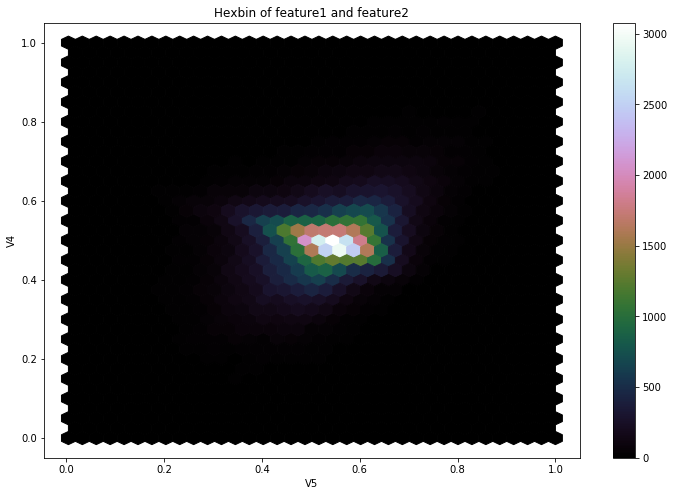

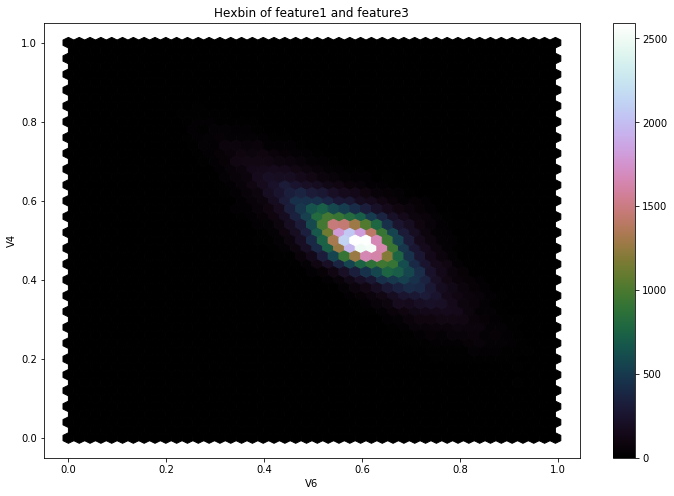

In [71]:
movie.plot(y= 'V4', x ='V5',kind='hexbin',gridsize=35, sharex=False, colormap='cubehelix', title='Hexbin of feature1 and feature2',figsize=(12,8))
movie.plot(y= 'V4', x ='V6',kind='hexbin',gridsize=45, sharex=False, colormap='cubehelix', title='Hexbin of feature1 and feature3',figsize=(12,8))

From the Hexbin plots, one can tell see that the correlation between IMDB score and gross is one that is quite obvious to explain while an interesting result thrown up is that of the score and the duration. ( Interesting!)

Anyway now - time for the customary heatmap per the tradition of most notebooks on Principal Component Analysis. The heatmap is generated to visually show how strongly correlated the values of the dataframe's columns are to one another. Therefore in this matrix the squares that are of a darker colour are more strongly correlated compared to the ones of lighter colour. 

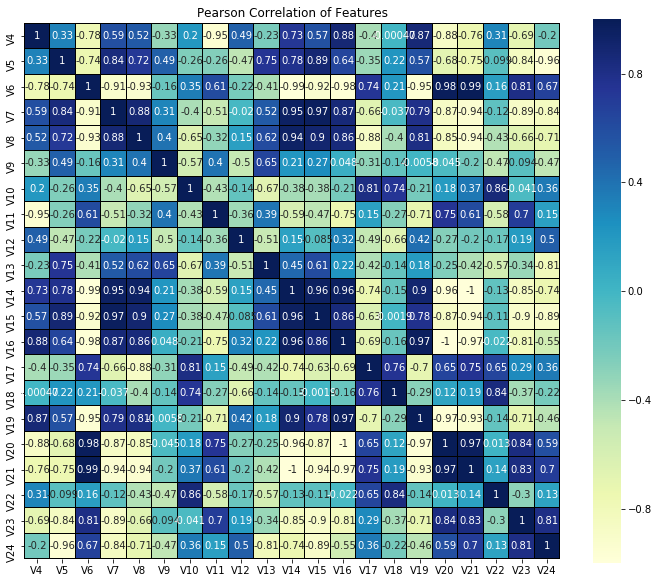

In [73]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
plt.title('Pearson Correlation of Features')
# Draw the heatmap using seaborn
sns.heatmap(X.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True)

As we can see from the heatmap, there are regions (features) where we can see quite positive linear correlations amongst each other, given the darker shade of the colours - top left-hand corner and bottom right quarter. This is a good sign as it means we may be able to find linearly correlated features for which we can perform PCA projections on.

# 2. EXPLAINED VARIANCE MEASURE
As alluded to in the Introduction, I will be using a particular measure called Explained Variance which will be useful in this context to help us determine the number of PCA projection components we should be looking at. Again this section heavily borrows from Sebastian Raschka's article on Principal Component Analysis so please follow his link for a much more detailed explanation on explained variance than I can do justice to : http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

In [74]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

Now having obtained the eigenvalues and eigenvectors, we will group them together by creating a list of eigenvalue, eigenvector tuples (immutable Python data objects). Following on from this we will sort the list  in order of Highest eigenvalue to lowest eigenvalue and then use the eigenvalues to calculate both the individual explained variance and the cumulative explained variance for visualisation.

In [75]:
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

Now time to plot the explained variance graphs to see how our contributions look like. The cumulative explained variance is visualised in a blue step-plot while the individual explained variance is plotted via green bar charts as follows: 

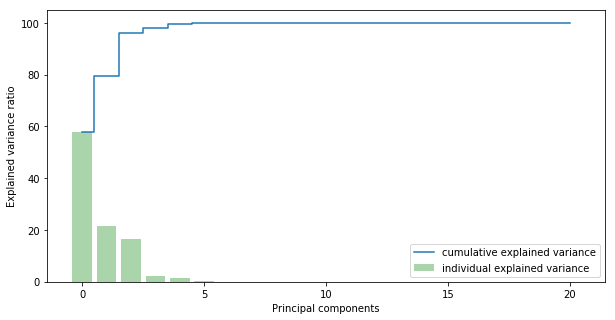

In [77]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.bar(range(21), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(21), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

From the plot above, it can be seen that approximately 90% of the variance can be explained with the 9 principal components. Therefore for the purposes of this notebook, let's implement PCA with 9 components ( although to ensure that we are not excluding useful information, one should really go for 95% or greater variance level which corresponds to about 12 components).

# 3. PRINCIPAL COMPONENT ANALYSIS 
Having roughly identified how many components/dimensions we would like to project on, let's now implement sklearn's PCA module. 

The first line of the code contains the parameters "n_components" which states how many PCA components we want to project the dataset onto. Since we are going implement PCA with 9 components, therefore we set n_components = 9.  

The second line of the code calls the "fit_transform" method, which fits the PCA model with the standardised movie data X_std and applies the dimensionality reduction on this dataset. 

In [78]:
pca = PCA(n_components=5)
x_5d = pca.fit_transform(X_std)
print(x_5d)

[[ -2.22418723   6.11602214   0.11492241   0.60585722  -0.39651919]
 [  6.5411428   -2.4683346    3.93772512  -0.64006324  -0.2326227 ]
 [ -4.87056429   3.31767478  -1.57442321  -0.16427516  -0.09337216]
 ..., 
 [ -1.67255383  -5.78648405   6.42590175  -1.2272035    0.08787856]
 [ 11.95813175  -1.61688846   3.24272962   0.49575973  -0.58287057]
 [ -0.96593707   0.78813838  -0.04075703   0.04964195   0.1644459 ]]


Awesome. Having now applied our specific PCA model with the movie dataset, let's visualise the first 2 projection components as a 2D scatter plot to see if we can get a quick feel for the underlying data. 

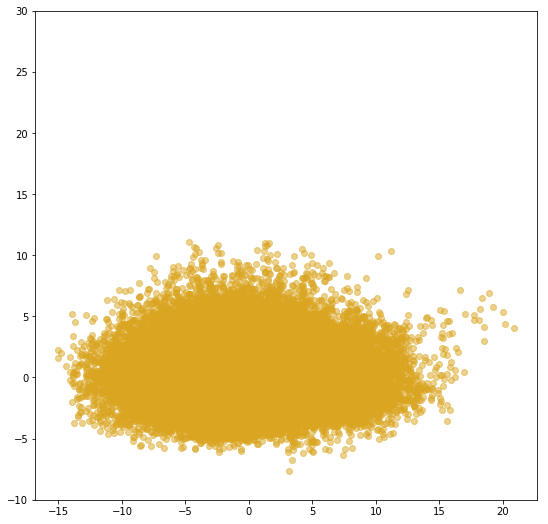

In [79]:
plt.figure(figsize = (9,9))
plt.scatter(x_5d[:,0],x_5d[:,2], c='goldenrod',alpha=0.5)
plt.ylim(-10,30)
plt.show()

As a quick aside, my aim (or hope) in carrying out this quick and dirty plotting is to see if we can observe distinct clusters already present within the plots which would be able to tell us if our PCA-transformed data can indeed be linearly separable into different groups for later use as our new features. 

However from the 2D plot above of the first 2 PCA projections, the first visual impression is that there does not seem to be any discernible clusters. However keeping in mind that our PCA projections contain another 7 components, perhaps looking at plots with the other components may be fruitful. For now, let us assume that will be trying a 3-cluster (just as a naive guess) KMeans to see if we are able to visualise any distinct clusters.

#4. VISUALISATIONS WITH KMEANS CLUSTERING
A simple KMeans will now be applied to the PCA projection data. Each cluster will be visualised with a different colour so hopefully we will be able to pick out clusters by eye. 

To start off, we set up a KMeans clustering with sklearn's KMeans() and call the "fit_predict" method to compute cluster centers and predict cluster indices for the first and third PCA projections (to see if we can observe any appreciable clusters). We then define our own colour scheme and plot the scatter diagram as follows:

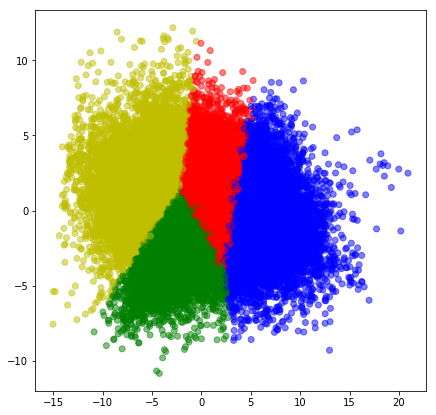

In [84]:
# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=4)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_5d)

# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g',2 : 'b',3 : 'y'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter diagram
plt.figure(figsize = (7,7))
plt.scatter(x_5d[:,0],x_5d[:,1], c= label_color, alpha=0.5) 
plt.show()

This KMeans plot looks more promising now as if our simple clustering model assumption turns out to be right, we can observe 3 distinguishable clusters via this color visualisation scheme.

Now, the plot above was only for 2 PCA projections out of the 9 projections that we currently have. However I would also like to generate a KMeans visualisation for other possible combinations of the projections against one another. I will use Seaborn's convenient **pairplot** function to do the job. Basically pairplot automatically plots all the features in the dataframe (in this case our PCA projected movie data) in pairwise manner. I will pairplot the first 3 projections against one another and the resultant plot is given below:

In [82]:
# Create a temp dataframe from our PCA projection data "x_5d"
df = pd.DataFrame(x_5d)
df = df[[0,1,2]] # only want to visualise relationships between first 3 projections
df['X_cluster'] = X_clustered

LinAlgError: singular matrix

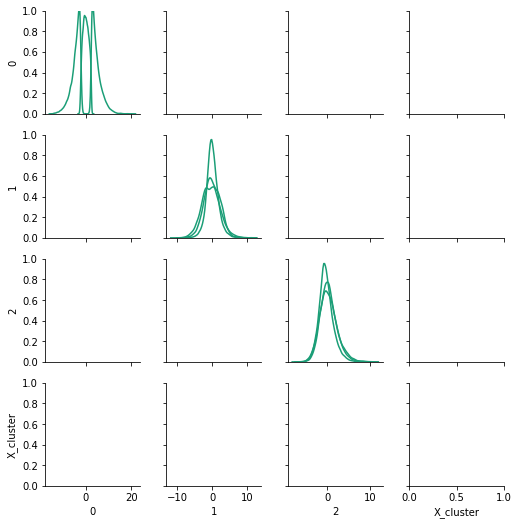

In [83]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

# Conclusion